In [1]:
import pandas as pd
import datetime
from pandas import Series, DataFrame

In [2]:
data = pd.read_csv('stock.csv')
data.sample(5)

,Date,Open,High,Low,Close,Adj Close,Volume
94,2019-02-04,167.410004,171.660004,167.279999,171.250000,169.221588,31495500
113,2019-03-04,175.690002,177.750000,173.970001,175.850006,174.512360,27436200
7,2018-09-27,223.820007,226.440002,223.539993,224.949997,221.512604,30181200
185,2019-06-14,191.550003,193.589996,190.300003,192.740005,192.010468,18761500
29,2018-10-29,219.190002,219.690002,206.089996,212.240005,208.996857,45935500


In [3]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
247,2019-09-12,224.800003,226.419998,222.860001,223.089996,223.089996,32226700
248,2019-09-13,220.000000,220.789993,217.020004,218.750000,218.750000,39763300
249,2019-09-16,217.729996,220.130005,217.559998,219.899994,219.899994,21158100
250,2019-09-17,219.960007,220.820007,219.119995,220.699997,220.699997,18318700
251,2019-09-18,221.059998,222.410004,220.679993,222.360001,222.360001,5459037


In [4]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-09-18,217.789993,221.850006,217.119995,218.240005,214.905167,31571700
1,2018-09-19,218.500000,219.619995,215.300003,218.369995,215.033142,27123800
2,2018-09-20,220.240005,222.279999,219.149994,220.029999,216.667816,26608800
3,2018-09-21,220.779999,221.360001,217.289993,217.660004,214.334030,96246700
4,2018-09-24,216.820007,221.259995,216.630005,220.789993,217.416183,27693400


In [5]:
close_px = data['Adj Close']
mavg = close_px.rolling(window=100).mean()
print(mavg)

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
247    199.726435
248    199.854917
249    199.998075
250    200.167890
251    200.364031
Name: Adj Close, Length: 252, dtype: float64


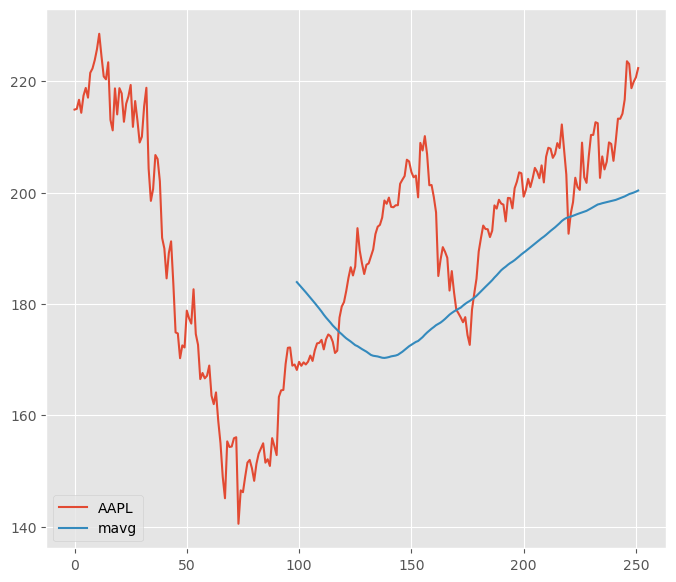

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__


style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

<Axes: >

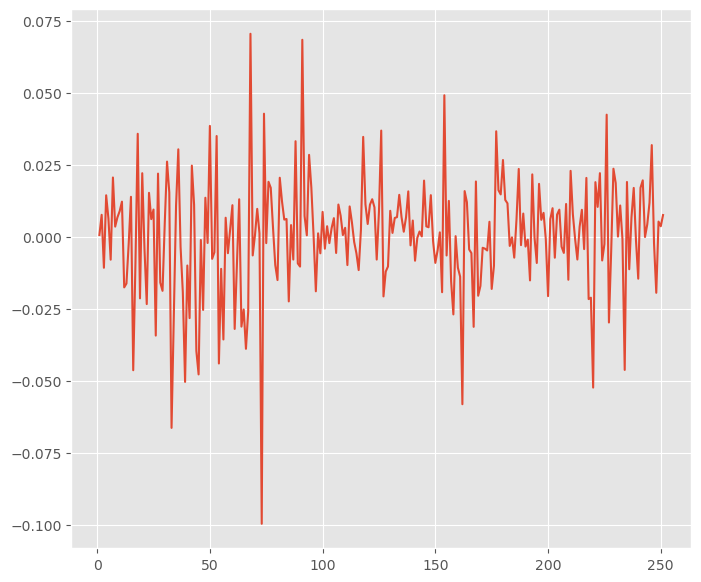

In [7]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [8]:
data_reg = data.loc[:,["Adj Close", "Volume"]]
data_reg["HL_PCT"] = (data["High"] - data["Low"]) / data["Close"] * 100.0
data_reg["PCT_change"] = (data["Close"] - data["Open"]) / data["Open"] * 100.0

In [9]:

data_reg.fillna(value=-99999, inplace=True)

import math
import numpy as np
from sklearn import preprocessing
forecast_out = int(math.ceil(0.01 * len(data_reg)))

forecast_col = "Adj Close"
data_reg["label"] = data_reg[forecast_col].shift(-forecast_out)
X = np.array(data_reg.drop(['label'], axis = 1))

X = preprocessing.scale(X)

X_lately = X[-forecast_out:]
X = X[:-forecast_out]

y = np.array(data_reg['label'])
y = y[:-forecast_out]

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [11]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:

clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('ridge', Ridge())])

In [13]:
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2)

In [14]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

In [15]:
print("The linear regression confidence is", confidencereg)

The linear regression confidence is 0.894472085714572


In [16]:
print("The quadratic regression 2 confidence is", confidencepoly2)
print("The quadratic regression 3 confidence is", confidencepoly3)
print("The KNN regression 2 confidence is", confidenceknn)

The quadratic regression 2 confidence is 0.8953649068614553
The quadratic regression 3 confidence is 0.8289395122412604
The KNN regression 2 confidence is 0.7949464146947978


In [17]:
forecast_set = clfreg.predict(X_lately)
data_reg['Forecast'] = np.nan

In [18]:
print(forecast_set)

[218.94014225 220.34350245 222.9024023 ]


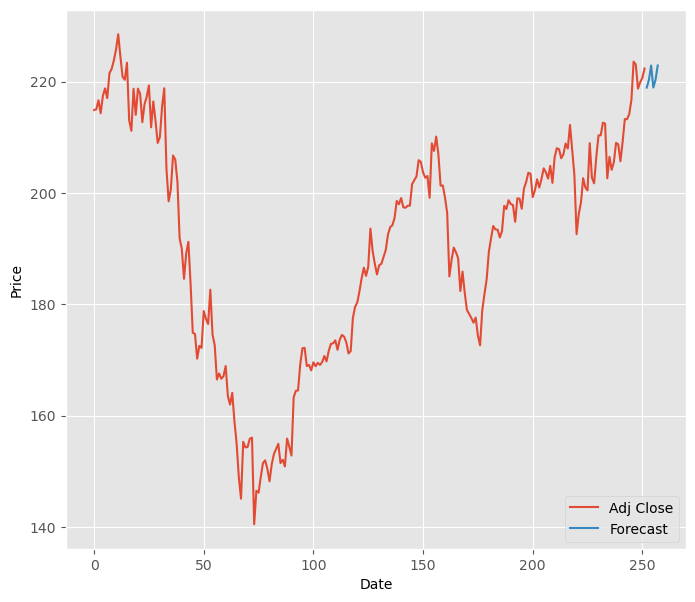

In [20]:
last_date = data_reg.iloc[-1].name
last_unix = last_date
next_unix = pd.to_datetime(data_reg.iloc[-1].name) + datetime.timedelta(days=1)


for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    data_reg.loc[next_date] = [np.nan for _ in range(len(data_reg.columns)-1)]+[i]
data_reg['Adj Close'].tail(500).plot()
data_reg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()